# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 定义回测区间

In [2]:
start_date = '2019-01-01'
end_date = '2025-01-01'

## 读入和处理数据

### 读入 ST 股票

读入全公司列表

In [3]:
issues = feather.read_dataframe('../data/issues_daily.feather')
issues_tot = issues['issue'].sort_values().unique()

读入 ST 股票

In [4]:
# sd.auth('*', '*')
# st = sd.get_st_issue(issues=list(issues_tot), start_date=start_date, end_date=end_date)
# st = st.set_index('date').stack().reset_index().rename(columns={'level_1': 'issue', 0: 'st'})
# feather.write_dataframe(st, '../data/st.feather')
st = feather.read_dataframe('../data/st.feather')

### 读入日线数据

读入日线数据

In [5]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')

计算调仓日

In [6]:
trade_date = price_1d['date'].sort_values().unique()
adj_date = trade_date[(trade_date >= start_date) & (trade_date <= end_date)]

计算每两个调仓日之间的收益

In [7]:
price_adj = price_1d.loc[(price_1d['date'] >= start_date) & (price_1d['date'] <= end_date), ['issue', 'date', 'ret']].copy()
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj.dropna(subset='ret_next')

剔除股票

In [8]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)
price_adj = pd.merge(
    price_adj,
    st,
    on=['issue', 'date'],
    how='left'
)
price_adj['st'] = price_adj['st'].ffill()
price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[~price_adj['st']]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

C:\Users\admin\AppData\Local\Temp\ipykernel_28944\2002057231.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_adj['st'] = price_adj['st'].ffill()


### 计算基准

中证 500

In [9]:
# sd.auth('*', '*')
# index_bar = sd.get_index_bar('000906', start_date='2018-12-28', end_date=end_date)
# index_bar['date'] = pd.to_datetime(index_bar['date'])
# index_bar = index_bar.drop(columns='_id')

# index_bar['ret'] = index_bar['close'] / index_bar['close'].shift(1) - 1
# index_bar['ret_next'] = index_bar['ret'].shift(-1)
# index_bar = index_bar.dropna()
# index_bar = index_bar.set_index('date')
# ret_index = index_bar[['ret', 'ret_next']]

# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_index, '../data/benchmark/benchmark_000906_daily.feather')
# ret_index

全样本等权

In [10]:
# ret_sample = (
#     price_adj
#         .groupby('date')[['ret', 'ret_next']].mean()
# )
# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_sample, '../data/benchmark/benchmark_sample_daily.feather')
# ret_sample

## IC 测试

In [11]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

### 计算分组收益和换手率

In [12]:
def grouped_ret(f, factor_col):
    f_date = f.copy()
    qcut = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

def top_weight(f, factor_col):
    f_date = f.copy()
    f_date['group'] = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    top = pd.Series(0., index=issues_tot)
    issues_top = f_date.loc[f_date['group'] == 10, 'issue'].to_list()
    top[issues_top] = 1 / len(issues_top)
    return top

def grouped_calc(factor, factor_col, factor_name=None):
    if factor_name == None:
        factor_name = factor_col
    f = pd.merge(
        factor,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )
    ret = (
        f
            .groupby('date')[[factor_col, 'ret', 'ret_next']]
            .apply(grouped_ret, factor_col=factor_col)
    )
    top = (
        f
            .groupby('date')[[factor_col, 'issue']]
            .apply(top_weight, factor_col=factor_col)
    )
    turnover = np.abs(top - top.shift(1)).sum(axis=1)
    return ret, turnover

### 画分组收益图和多空收益曲线

In [13]:
def grouped_plot(ret, ret_excess, dirname=None):
    ret_annual = (1 + ret.mean()) ** 252 - 1
    plt.bar(ret_annual.index, ret_annual, color='#a60021')
    plt.xlabel('Group')
    plt.ylabel('Annualized Return')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    if dirname == None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/grouped_' + factor_name + '.png')
        plt.close()
    
    long = (1 + ret[10]).cumprod()
    long_excess = (1 + ret_excess[10]).cumprod()
    long_short = (1 + ret[10] - ret[1]).cumprod()

    fig, ax1 = plt.subplots()
    ax1.plot(long, linewidth=3, color='#a60021', label='long')
    ylim = ax1.get_ylim()
    ax1.fill_between(
        long_excess.index, 0, long_excess,
        color='#a5a5a5', label='long_excess',
    )
    ax1.set_ylim(ylim)
    ax1.set_ylabel('Net Value (long)')
    ax1.grid()
    
    ax2 = ax1.twinx()
    ax2.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
    ax2.set_ylabel('Net Value (long-short)')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Time')
    if dirname == None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/nv_' + factor_name + '.png')
        plt.close()

### 计算最大回撤

In [14]:
def max_drawdown_calc(ret):
    cumret = (1 + ret).cumprod()
    running_max = cumret.cummax()
    drawdown = cumret / running_max - 1
    return drawdown.min()

## 一键回测

In [15]:
def backtest(filename, factor_col, factor_name=None, benchmark=None, dirname=None):
    if factor_name == None:
        factor_name = factor_col
    factor = feather.read_dataframe(filename)

    df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'winning', 'IC_IR', 't', 'max', 'min'])
    IC = IC_calc(factor, factor_col=factor_col)

    sign = np.sign(IC.mean())
    factor[factor_col] *= sign

    winning = (np.sign(IC) == sign).sum() / len(IC)
    df_IC.loc[0] = [
        factor_name,
        IC.mean(),
        winning,
        IC.mean() / IC.std(),
        np.sqrt(len(IC)) * IC.mean() / IC.std(),
        IC.max(),
        IC.min()
    ]

    df_grouped = pd.DataFrame(columns=[
        'factor',
        'long_annual', 'excess_annual', 'long_sharpe',
        'long_short',
        'max_drawdown', 'turnover_annual'
    ])
    grouped, turnover = grouped_calc(
        factor, factor_col=factor_col,
        factor_name=factor_name
    )
    if benchmark != None:
        ret_benchmark = feather.read_dataframe(benchmark)
    ret_benchmark = ret_benchmark.reindex(grouped.index)
    excess = grouped.sub(ret_benchmark['ret_next'], axis=0)

    grouped_plot(grouped, excess)
    
    long_annual = (1 + grouped[10].mean()) ** 252 - 1
    excess_annual = (1 + excess[10].mean()) ** 252 - 1
    std_annual = np.sqrt(252) * excess[10].std()
    long_short = (1 + (grouped[10] - grouped[1]).mean()) ** 252 - 1
    max_drawdown = max_drawdown_calc(grouped[10] - grouped[1])
    turnover_annual = turnover.mean() * 252
    df_grouped.loc[0]=[
        factor_name,
        long_annual,
        excess_annual,
        excess_annual / std_annual,
        long_short,
        max_drawdown,
        turnover_annual
    ]
    
    return df_IC, df_grouped

### 一组因子回测

In [16]:
def set_backtest(filenames, factor_cols, factor_names, benchmark, dirnames=None):
    if factor_names is None:
        factor_names = factor_cols
    if dirnames is None:
        dirnames = [None] * len(filenames)
    IC = None
    grouped = None
    for filename, factor_col, factor_name, dirname in zip(filenames, factor_cols, factor_names, dirnames):
        IC_factor, grouped_factor = backtest(
            filename=filename,
            factor_col=factor_col, factor_name=factor_name,
            benchmark=benchmark, dirname=dirname
        )
        IC = pd.concat([IC, IC_factor])
        grouped = pd.concat([grouped, grouped_factor])
    display(IC)
    display(grouped)

## 跳跃收益因子回测

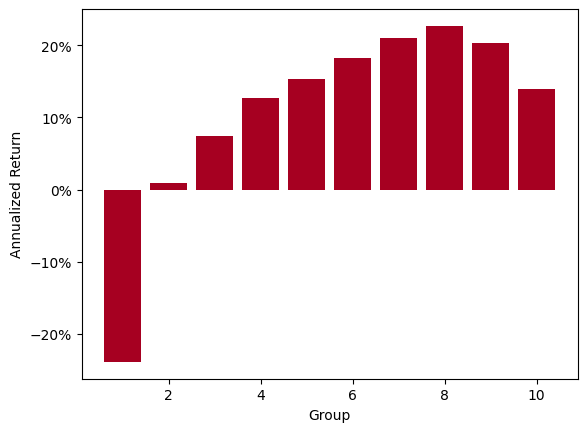

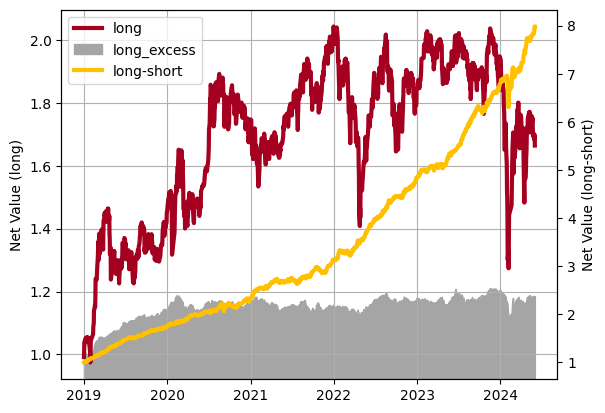

,factor,IC_mean,winning,IC_IR,t,max,min
0,ret_jump_neutral,-0.037254,0.766768,-0.68972,-24.982706,0.252839,-0.293245


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,ret_jump_neutral,0.139347,0.034201,0.676676,0.496567,-0.094026,104.098469


In [17]:
IC, grouped = backtest(
    filename='../data/ret_jump_daily/neutral_ret_jump.feather',
    factor_col='neutral_factor', factor_name='ret_jump_neutral',
    benchmark='../data/benchmark/benchmark_sample_daily.feather'
)
display(IC)
display(grouped)

## 点度中心性回测

### N_connect_0_1

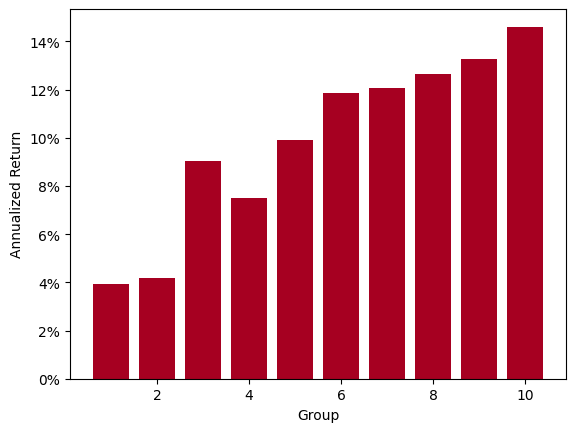

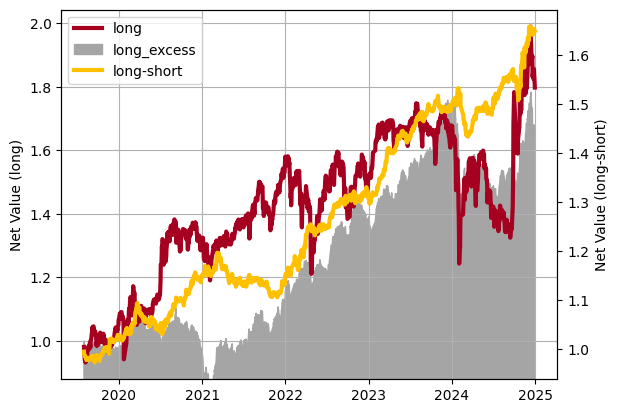

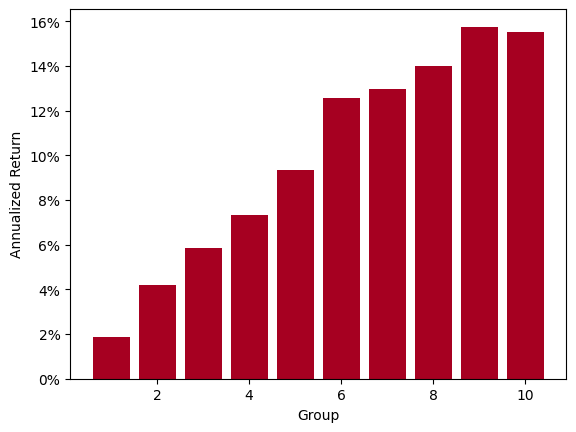

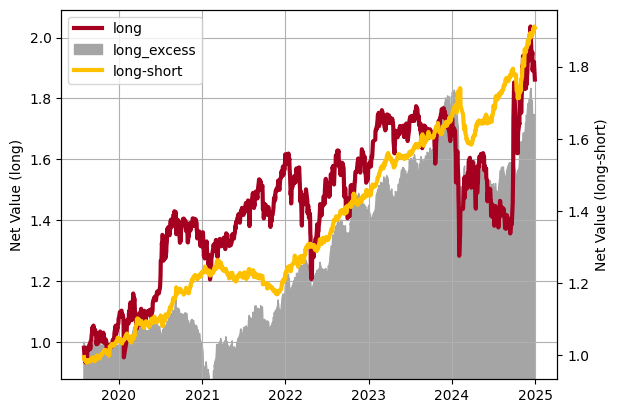

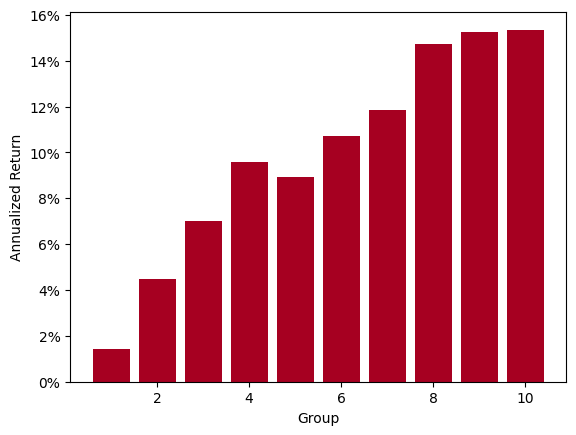

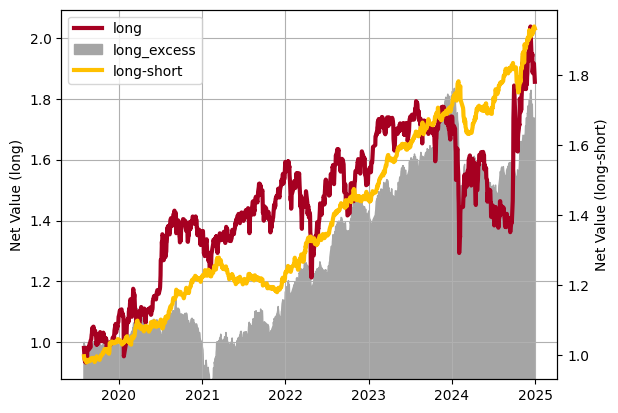

,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,0.016868,0.642314,0.366764,13.294863,0.210242,-0.144425
0,N_connect_size,0.018185,0.661339,0.395516,14.337113,0.191593,-0.183746
0,N_connect,0.018942,0.652968,0.391465,14.190280,0.203052,-0.163709


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.146104,0.111731,0.818359,0.102571,-0.076128,114.734050
0,N_connect_size,0.155113,0.120470,0.876103,0.133815,-0.089692,34.535057
0,N_connect,0.153550,0.118955,0.868855,0.137107,-0.084585,70.336894


In [18]:
cores = np.array(['_num', '_size', ''])
filenames = '../data/N_connect_daily/N_connect_0_1/neutral_N_connect' + cores + '.feather'
factor_cols = ['neutral_factor'] * 3
factor_names = 'N_connect' + cores
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906_daily.feather',
)

### N_connect_1_any

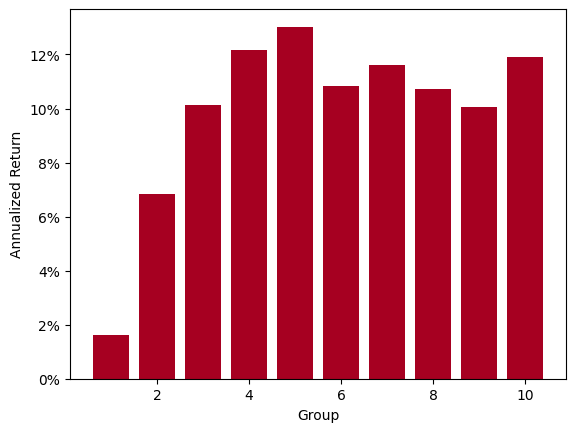

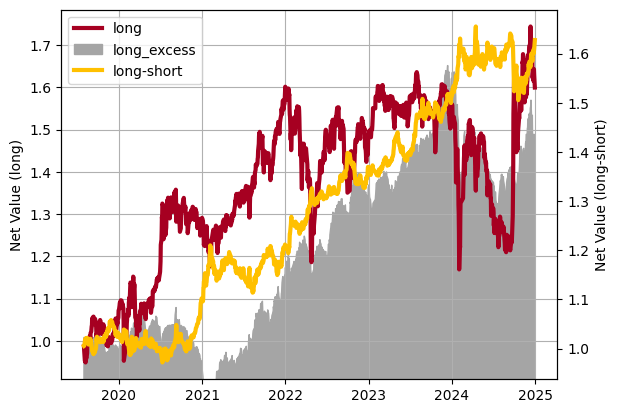

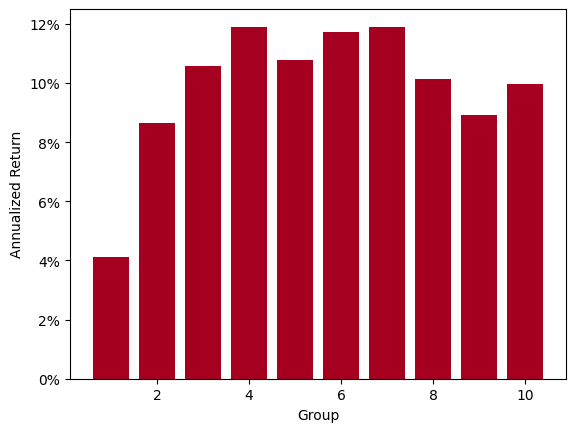

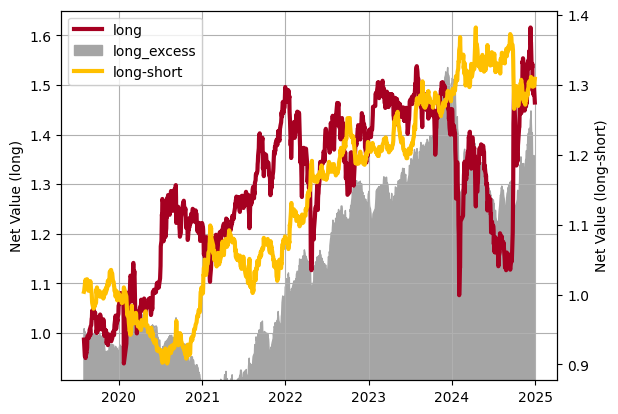

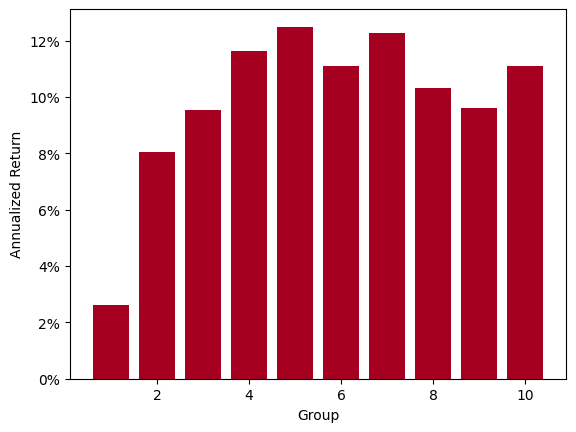

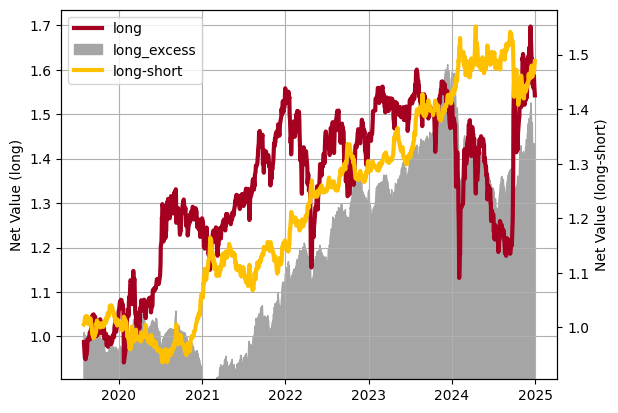

,factor,IC_mean,winning,IC_IR,t,max,min
0,N_connect_num,-0.015686,0.574581,-0.199529,-7.232747,0.225469,-0.252475
0,N_connect_size,-0.013074,0.569254,-0.174225,-6.315508,0.221153,-0.222306
0,N_connect,-0.014674,0.573820,-0.187020,-6.779318,0.229342,-0.247214


,factor,long_annual,excess_annual,long_sharpe,long_short,max_drawdown,turnover_annual
0,N_connect_num,0.119174,0.085605,0.684129,0.101161,-0.090515,69.931517
0,N_connect_size,0.099598,0.066614,0.525037,0.056099,-0.129288,30.714357
0,N_connect,0.111082,0.077755,0.614888,0.082599,-0.100850,46.150522


In [19]:
cores = np.array(['_num', '_size', ''])
filenames = '../data/N_connect_daily/N_connect_1_any/neutral_N_connect' + cores + '.feather'
factor_cols = ['neutral_factor'] * 3
factor_names = 'N_connect' + cores
set_backtest(
    filenames=filenames,
    factor_cols=factor_cols, factor_names=factor_names,
    benchmark='../data/benchmark/benchmark_000906_daily.feather',
)

## 跳跃关联动量因子回测